In [191]:
import pandas as pd
commodity = 'corn'
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import dataloader
import LSTM

In [205]:
train_loader = dataloader.get_dataloader('corn', 20, 'train', 10)
validation_loader = dataloader.get_dataloader('corn', 20, 'val', 100)

In [206]:
model = LSTM.CommodityLSTM(validation_loader)

In [207]:
training_losses, validation_losses = model.train(train_loader, validation_loader)

TRAINING BATCH LOSS AT STEP 0: 0.18179795145988464
VALIDATION BATCH LOSS AT STEP 0: 0.18037371337413788
TRAINING BATCH LOSS AT STEP 50: 0.09102527052164078
VALIDATION BATCH LOSS AT STEP 50: 0.08912263810634613
TRAINING BATCH LOSS AT STEP 100: 0.033862292766571045
VALIDATION BATCH LOSS AT STEP 100: 0.03290628269314766
TRAINING BATCH LOSS AT STEP 150: 0.006765330675989389
VALIDATION BATCH LOSS AT STEP 150: 0.0064055658876895905
TRAINING BATCH LOSS AT STEP 200: 0.00027048983611166477
VALIDATION BATCH LOSS AT STEP 200: 0.0005468263407237828
TRAINING BATCH LOSS AT STEP 250: 5.269304529065266e-05
VALIDATION BATCH LOSS AT STEP 250: 0.00014950682816561311
TRAINING BATCH LOSS AT STEP 300: 2.702151505218353e-05
VALIDATION BATCH LOSS AT STEP 300: 0.00014259804447647184
TRAINING BATCH LOSS AT STEP 350: 3.4429089282639325e-05
VALIDATION BATCH LOSS AT STEP 350: 0.00014257269504014403
TRAINING BATCH LOSS AT STEP 400: 3.899812145391479e-05
VALIDATION BATCH LOSS AT STEP 400: 0.00014275974535848945
TRAI

In [208]:
training_losses = torch.stack(training_losses).detach().numpy()
validation_losses = torch.stack(validation_losses).detach().numpy()

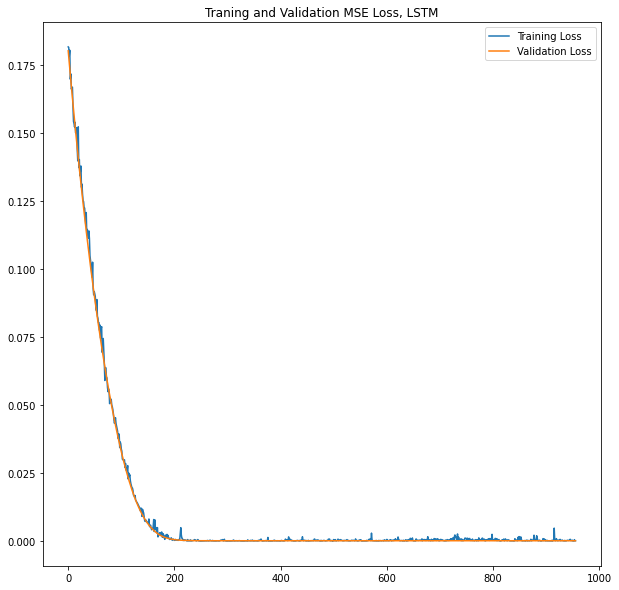

In [216]:
plt.figure(figsize = (10,10))
plt.title('Traning and Validation MSE Loss, LSTM')
plt.plot(training_losses, label= 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')
plt.legend()